# Building a Spam Filter with Naive Bayes
Building a spam filter for SMS messages is a practical and useful application of machine learning algorithms that can help users avoid being bombarded with unwanted messages and improve their overall experience.

![](https://www.informaticsinc.com/application/files/4515/2718/5763/iStock-122143117.jpg)

In this project, we will delve into the practical application of algorithms by building a spam filter for SMS messages. The aim of this project is to train a computer to classify SMS messages as either spam or non-spam with an accuracy greater than 80%. This will be done by:
- leveraging human knowledge of how messages are classified
- using the information above to estimate the probability of a new message being either spam or non-spam. 
- having the computer classify messages as either spam or non-spam based on the probability values.

To achieve this, we will use the **Multinomial Naive Bayes** algorithm along with a dataset of 5,572 SMS messages that have already been classified by humans. Tiago A. Almeida and José María Gómez Hidalgo compiled the [dataset](https://dq-content.s3.amazonaws.com/433/SMSSpamCollection), which is available for download from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/sms+spam+collection).

> _If you want to learn more about how the data used in this project was collected, you can visit [this page](http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/#composition). Additionally, the page also contains papers authored by the creators of the dataset, which you may find useful._

> _Due to the nature of spam messages, the dataset contains content that may be offensive to some users._

The dataset comprises pre-labelled SMS messages that have been labelled as either spam or non-spam and will be used to train the algorithm. Once the algorithm is trained, it can be used to classify new messages as spam or non-spam.

## Importing Libraries
---

In [1]:
import io
import random
import re
import zipfile

import matplotlib.pyplot as plt
import pandas as pd
import requests
from stop_words import get_stop_words
from wordcloud import STOPWORDS, WordCloud

# Set the default behaviour of plots
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Exploring the Dataset
---

### 1. Downloading the dataset
First, we will download the file from the url using the [requests](https://pypi.org/project/requests/) library, then extract the contents into a local folder. To extract these contents, we use the [zipfile](https://docs.python.org/3/library/zipfile.html) library.

In [2]:
# Pull the data from the url
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip"
response = requests.get(url)

# Extract the contents into a folder locally
folder_name = url.split("/")[-1][:-4]
z = zipfile.ZipFile(io.BytesIO(response.content))
z.extractall("./" + folder_name)

# Check if the extraction process was successful
! ls

fonts             notebook.ipynb    smsspamcollection


### 2. Checking the file structure
Next, we will check how the file contents are structured (by displaying the first five rows of the file). Understanding how the data is structured makes it easier to work with the data in Pandas.

In [3]:
# Preview from the command line
! cd smsspamcollection; head -n 5 SMSSpamCollection; cd ../

ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
ham	Ok lar... Joking wif u oni...
spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
ham	U dun say so early hor... U c already then say...
ham	Nah I don't think he goes to usf, he lives around here though


The data lacks a header row, and the columns are separated by tabs. We can account for these structural attributes when reading the data with Pandas.
### 3. Exploring with Pandas
Finally, we can read the dataset and explore its attributes further:

In [4]:
# Read-in the data with pandas
df = pd.read_csv(
    "./smsspamcollection/SMSSpamCollection",
    sep="\t",
    header=None,
    names=["label", "SMS"],
)


# Explore dataset attributes
print(
    f"STRUCTURE:\nThe SMS dataset has {df.shape[0]} rows and {df.shape[1]} columns.\n"
)
print(
    f"COMPLETENESS:\nThe dataset has {df.isnull().sum().sum()} number of null values.",
    "\n",
)

print("PREVIEW:\nPrinting the first five rows of the dataset...")
df.head()

STRUCTURE:
The SMS dataset has 5572 rows and 2 columns.

COMPLETENESS:
The dataset has 0 number of null values. 

PREVIEW:
Printing the first five rows of the dataset...


,label,SMS
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
# Check the proportion of spam vs ham messages
print(
    "SPAM VS HAM (NON-SPAM):\n\
Printing the proportion on spam vs ham messages..."
)
df.label.value_counts(normalize=True).to_frame(name="proportion")

SPAM VS HAM (NON-SPAM):
Printing the proportion on spam vs ham messages...


,proportion
ham,0.865937
spam,0.134063


Of the total number of SMS messages in the dataset, about 87% are classified as "ham" and the remaining 13% are classified as "spam". This indicates that the dataset is representative of the actual message distribution in practice, where most of the messages people receive are legitimate messages ("ham") rather than unsolicited messages ("spam"). 

Therefore, the dataset can be considered appropriate for training our filter to accurately distinguish between spam and ham messages, which will ultimately result in an effective spam filter for SMS messages.

## Creating the Training and Test Datasets
---
We found that about 87% of the messages in the dataset are ham and 13% are spam. To build a spam filter, it is helpful to first design a test to ensure that the filter works effectively. 

We will split our dataset into two categories as follows:
1. A training set for teaching the computer how to classify messages.
2. A test set for evaluating the performance of the spam filter. 
> _We'll keep **80%** for training and **20%** for testing._ 

Our aim is to create a spam filter that can classify new messages with an accuracy greater than 80%. To test this, we will compare the results of the algorithm's classification with that of the human classification on the test set.

In [6]:
# Randomize entire dataframe
randomized_df = df.sample(frac=1, random_state=1)

# Create training and test set
num_records = randomized_df.shape[0]
train_set_size = round(num_records * 0.8)

train_set = randomized_df.iloc[:train_set_size].reset_index(drop=True)
test_set = randomized_df.iloc[train_set_size:].reset_index(drop=True)

# Verify training set as 80% and test set as 20% of dataframe
assert train_set.shape[0] == round(0.8 * randomized_df.shape[0])
assert test_set.shape[0] == round(0.2 * randomized_df.shape[0])
print(f"The training set has {train_set.shape[0]} records.")
print(f"The test set has {test_set.shape[0]} records.")

The training set has 4458 records.
The test set has 1114 records.


In the next step, we will examine the proportion of spam and ham messages in both the training and test sets. We anticipate that these proportions will be similar to the ones found in the complete dataset, where approximately 87% of the messages are ham and the remaining 13% are spam.

In [7]:
print("Calculating spam vs ham proportions...")

pd.concat(
    [
        df.label.value_counts(normalize=True).round(2),
        train_set.label.value_counts(normalize=True).round(2),
        test_set.label.value_counts(normalize=True).round(2),
    ],
    axis=1,
    keys=["full_dataset", "train_set", "test_set"],
)

Calculating spam vs ham proportions...


,full_dataset,train_set,test_set
ham,0.87,0.87,0.87
spam,0.13,0.13,0.13


Since the proportions resemble those of the full dataset, our sampling method is deemed representative, and we can proceed.

## Cleaning the Dataset
---
The Naive Bayes algorithm we'll be using for the spam filter is based on the following two equations, where the letter _w_ denotes words in each SMS:

$$ P(Spam\mid w_1, w_2,...,w_n) \propto P(Spam) \cdot \prod\limits_{i=1}^{n}P(w_i\mid Spam)$$

$$ P(Ham\mid w_1, w_2,...,w_n) \propto P(Ham) \cdot \prod\limits_{i=1}^{n}P(w_i\mid Ham)$$


By analyzing these equations, we can see that each word in the message plays an essential role in helping the algorithm to classify messages as spam or ham. As a result, we will treat every word in each SMS as a variable.

However, we have to consider the fact that our dataset should be tidy for our purposes. In general, for data to be considered tidy, it must meet three criteria:

1. Each column should be a variable. In our case, we will treat every unique word in each SMS as a variable, so we have multiple columns for each SMS.
2. Every row should be an observation. In our case, each row will describe an SMS, with the number of times each unique word occurs in it.
3. Third, every cell should contain a single value.

> _To get a thorough knowledge of data tidiness rules, read [this article](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html)._


### 1. Letter Case and Punctuation
In addition to treating every word as a variable in our Naive Bayes algorithm, we will also make the algorithm case and punctuation insensitive. This means that the algorithm will not differentiate between uppercase and lowercase letters, and will ignore any punctuation marks in the messages.

For example, the words "FREE" and "free" will be treated as the same word, and the algorithm will not distinguish between them. Similarly, the presence of a punctuation mark such as a period or exclamation mark at the end of a sentence will not affect the classification of the message as spam or ham.

By making the algorithm case and punctuation insensitive, we can simplify the classification process and reduce the number of variables that the algorithm needs to consider. This can help improve the accuracy of the classification by reducing the potential for errors caused by case or punctuation differences in similar words or phrases.

In [8]:
train_set["SMS"] = train_set.SMS.str.replace("\W", " ", regex=True).str.lower()

train_set.head(5)

,label,SMS
0,ham,yep by the pretty sculpture
1,ham,yes princess are you going to make me moan
2,ham,welp apparently he retired
3,ham,havent
4,ham,i forgot 2 ask ü all smth there s a card on ...


### 2. Creating the Vocabulary
> _The vocabulary represents the list of all of the unique words that occur in all SMS messages of our training set._

In [9]:
# Split each SMS into a python list
train_set["SMS"] = train_set["SMS"].str.split()

# Append all the words in each list into a vocabulary
vocabulary = []
train_set["SMS"].apply(lambda x: [vocabulary.append(item) for item in x])

# Only retain the unique words in the vocabulary
vocabulary = list(set(vocabulary))

# Check the number of unique words in the vocabulary
print("Our vocabulary has {:,} unique words".format(len(vocabulary)))

Our vocabulary has 7,783 unique words


### 3. The Final Training Set
We can create a tidy dataframe by using the words in our vocabulary. This dataframe will have distinct columns for each unique word. Each column will store the number of times the word appears in an SMS message.

In [10]:
# Initialize a dictionary with each vocabulary word as keys and the length of the dataset as values
word_count_per_SMS = {word: [0] * train_set.shape[0] for word in vocabulary}

# Estimate the number of times each unique word apears in each SMS message
for index, words in enumerate(train_set.SMS):
    for word in words:
        word_count_per_SMS[word][index] += 1

# Covert results into a Pandas dataframe
word_count_df = pd.DataFrame(word_count_per_SMS)
word_count_df.head()

,qi,neva,yowifes,goin2bed,beside,upgrdcentre,anythin,lunch,complexities,day,...,09066660100,freephone,pt2,chess,south,there,voda,justfound,2hook,outfit
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [11]:
# Concatenate the training set datframe with the word counts dataframe
train_set_clean = pd.concat([train_set, word_count_df], axis=1)
train_set_clean.head()

,label,SMS,qi,neva,yowifes,goin2bed,beside,upgrdcentre,anythin,lunch,...,09066660100,freephone,pt2,chess,south,there,voda,justfound,2hook,outfit
0,ham,"[yep, by, the, pretty, sculpture]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ham,"[yes, princess, are, you, going, to, make, me,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ham,"[welp, apparently, he, retired]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ham,[havent],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ham,"[i, forgot, 2, ask, ü, all, smth, there, s, a,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


## Calculating Constants First
---
After completing the data cleaning process and obtaining a training dataset, we can now start building the spam filter using the Naive Bayes algorithm. In order to classify new messages, the algorithm requires the probability values of the two equations provided below:

$$ P(Spam\mid w_1, w_2,...,w_n) \propto P(Spam) \cdot \prod\limits_{i=1}^{n}P(w_i\mid Spam)$$

$$ P(Ham\mid w_1, w_2,...,w_n) \propto P(Ham) \cdot \prod\limits_{i=1}^{n}P(w_i\mid Ham)$$

Moreover, in order to calculate _P(w<sub>i</sub>|Spam)_ and _P(w<sub>i</sub>|Ham)_ in the equations above, we need to utilize the following formulas:

$$ P(w_i\mid Spam) = \frac{N_{(w_i\mid Spam)} + \alpha}{N_{spam} + \alpha \cdot N_{Vocabulary}} $$

$$ P(w_i\mid Ham) = \frac{N_{(w_i\mid Ham)} + \alpha}{N_{Ham} + \alpha \cdot N_{Vocabulary}} $$

It's important to note that some of the terms in these four equations will have identical values for every new message. Therefore, we can calculate the values of these terms once and avoid re-computing them every time a new message is received. To achieve this, we will use our training dataset to calculate:

1. The probability of spam and ham messages in the training set: P(Spam) and P(Ham).

2. The total number of words in all spam messages and ham messages: N<sub><i>Spam</i></sub> and N<sub><i>Ham</i></sub>.

3. The total number of unique words in all spam messages and ham messages: N<sub><i>Vocabulary</i></sub>.

> _For the smoothing constant ($\alpha$), we will use Laplace smoothing and set $\alpha$ = 1._

Once we have these calculations, we can easily determine the probability of a new message being spam or ham based on its word frequency. This approach will allow the Naive Bayes algorithm to more efficiently and accurately classify new messages.


In [12]:
# Create a dictionary to hold the constants
constants = {
    # Probability of spam
    "p_spam": train_set_clean.label.value_counts(normalize=True)["spam"],
    # Probability of non spam
    "p_ham": train_set_clean.label.value_counts(normalize=True)["ham"],
    # number of words in all spam messages
    "n_spam": train_set_clean.groupby("label").sum().sum(axis=1)["spam"],
    # number of words in all non spam messages
    "n_ham": train_set_clean.groupby("label").sum().sum(axis=1)["ham"],
    # number of unique words in vocabulary
    "n_vocabulary": len(word_count_per_SMS),
    # Laplace smooting constant
    "alpha": 1,
}

# Preview the values of the constants
print("Creating a table of constants...")
pd.DataFrame(constants, index=["values"])

Creating a table of constants...


,p_spam,p_ham,n_spam,n_ham,n_vocabulary,alpha
values,0.13459,0.86541,15190,57237,7783,1


## Calculating Parameters
---
Using the constant terms calculated earlier, we can proceed to calculate the parameters for _P(w<sub>i</sub>|Spam)_ and _P(w<sub>i</sub>|Ham)_, which will be the conditional probability values for each word in our vocabulary. To calculate these parameters, we will use the following formulas:

$$ P(w_i\mid Spam) = \frac{N_{(w_i\mid Spam)} + \alpha}{N_{spam} + \alpha \cdot N_{Vocabulary}} $$

$$ P(w_i\mid Ham) = \frac{N_{(w_i\mid Ham)} + \alpha}{N_{Ham} + \alpha \cdot N_{Vocabulary}} $$

In [13]:
# Initialize a dictionary of spam and ham parameters
spam_parameters = {item: 0 for item in vocabulary}
ham_parameters = {item: 0 for item in vocabulary}

# Isolate spam and ham messages from the training set
spam_messages = train_set_clean.loc[train_set_clean["label"] == "spam"]
ham_messages = train_set_clean.loc[train_set_clean["label"] == "ham"]

# Calculate parameters
for word in vocabulary:
    p_word_given_spam = (spam_messages[word].sum() + constants["alpha"]) / (
        constants["n_spam"] + constants["alpha"] * constants["n_vocabulary"]
    )

    p_word_given_ham = (ham_messages[word].sum() + constants["alpha"]) / (
        constants["n_ham"] + constants["alpha"] * constants["n_vocabulary"]
    )

    spam_parameters[word] = p_word_given_spam
    ham_parameters[word] = p_word_given_ham

## Common Words in Spam Messages
---
With the information we have gathered so far, we can try to identify the most common words found in spam messages. One approach would be to gather the SMS text in all spam messages of the training set together and visualize them using a word cloud:

In [14]:
# Pull a copy of the training set from the randomised dataframe
trainset_copy = randomized_df.iloc[:train_set_size].reset_index(drop=True)

# Isolate the spam SMS and pre-clean the set
spam_copy = trainset_copy.query("label == 'spam'").copy()

spam_copy["SMS"] = spam_copy.SMS.str.replace("\W", " ", regex=True).str.lower()

# Combine all spam sms into one text string
text = " ".join(spam_copy.SMS)

In [15]:
def show_wordcloud(wordcloud, size):
    """Defines a set of wordcloud display attributes"""
    plt.figure(figsize=size)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(
        "Most common words in spam messages",
        size=30,
        loc="left",
        fontfamily="Arial",
        pad=15,
    )


def grey_color_func(
    word, font_size, position, orientation, random_state=None, **kwargs
):
    """Sets wordcloud text color to random shades of gray"""
    return "hsl(0, 0%%, %d%%)" % random.randint(60, 100)


def create_wordcloud(text_string):
    """Creates a word cloud from text string"""
    wordcloud = WordCloud(
        font_path="./fonts/RobotoCondensed-Regular.ttf",
        width=3000,
        height=2000,
        max_words=500,
        random_state=42,
        collocations=False,
        background_color="#1a1a1d",
    ).generate(text_string)

    wordcloud.recolor(color_func=grey_color_func)
    show_wordcloud(wordcloud, (10, 10))

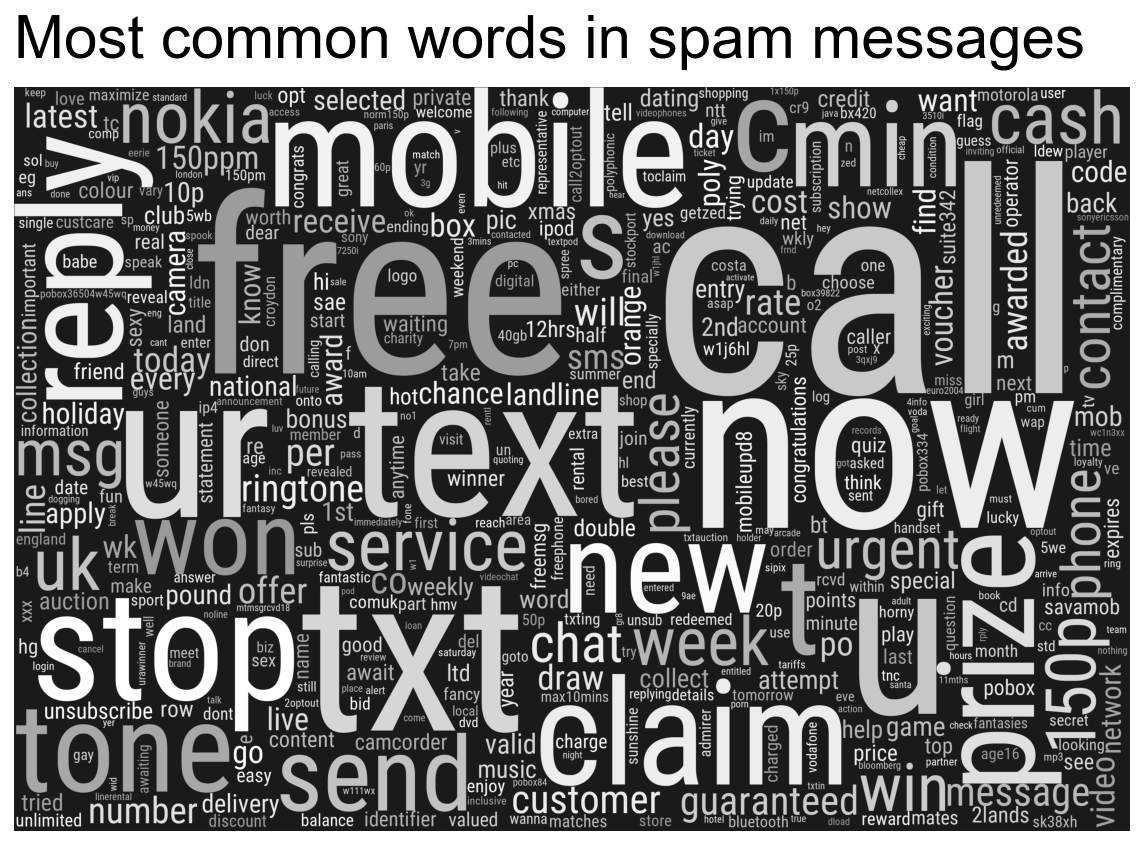

In [16]:
create_wordcloud(text)

The current word cloud displays some words that may be found in spam messages. However, these words may also appear in non-spam messages. For example, common words like "free" and "call" can arguably be found in both types of messages. To ensure that the words in our word cloud are unique to spam messages, we need to apply three filters to our text string:
1. First, we will remove common stop words, such as articles and prepositions, which do not add much meaning. 
2. Next, we will eliminate words with a length of fewer than three characters, which are typically pronouns and conjunctions. 
3. Finally, we will remove any words that occur frequently in non-spam messages in our training set. We will follow a thorough approach of removing any word that appears more than five times in ham messages. 

By applying these filters, we can identify words that are predominantly found in spam messages (to some extent).


In [17]:
# Get english stopwords from the stop word library
stop_words = list(get_stop_words("en"))

# Add them to the list of stopwords in the wordcloud library
STOPWORDS = list(STOPWORDS) + stop_words

# Create a list of frequent words (freq > 5) in ham messages
ham_data = train_set_clean.loc[train_set_clean["label"] == "ham"]
ham_words = ham_data.iloc[:, 2:].sum()
common_ham_words = ham_words[ham_words > 5]

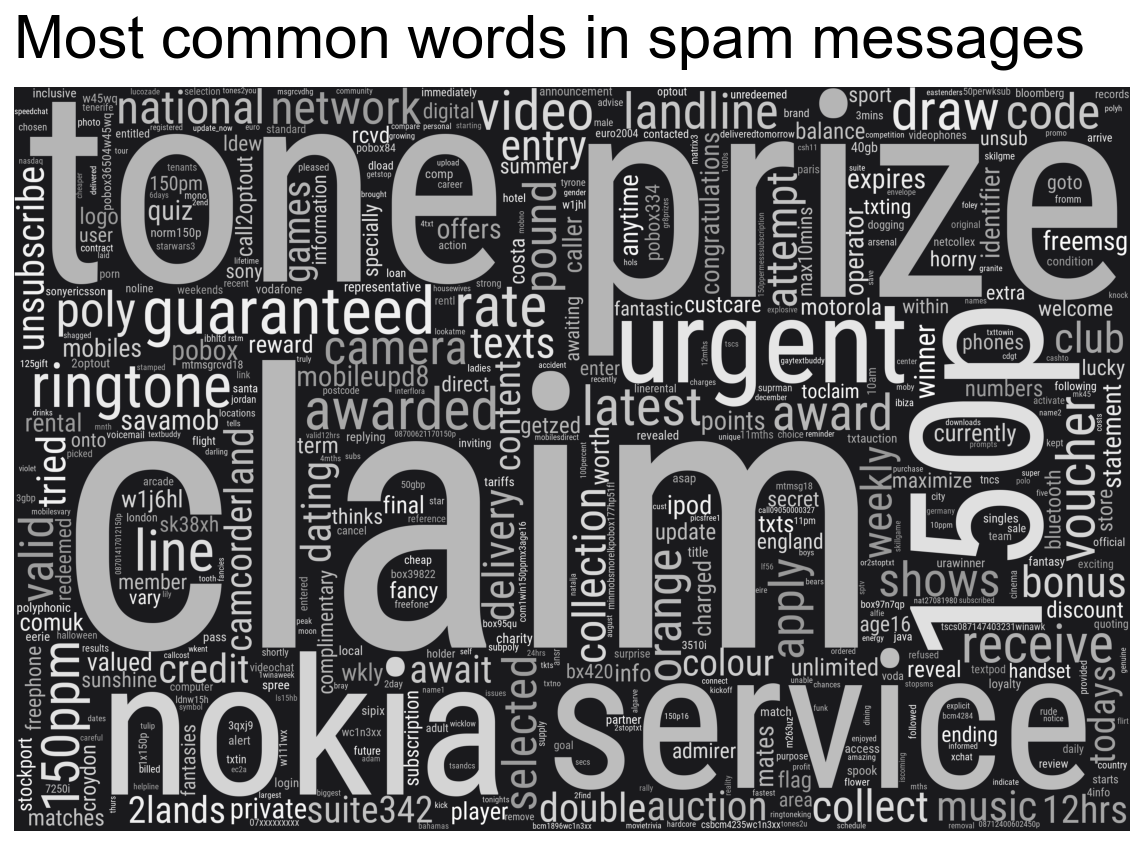

In [18]:
# --- Pass spam text through a 3 tier filter ---
# 1. A stopword filter
text = " ".join([word for word in text.split() if word not in STOPWORDS])
# 2. A filter for words with length greater than 3
text = " ".join([word for word in text.split() if len(word) > 3])
# 3. A filter for words not popular in ham messages
text = " ".join([word for word in text.split() if word not in common_ham_words.index])

# Generate an updated wordcloud
create_wordcloud(text)

Here, we see that spam messages often use certain tactics to entice people into taking specific actions. The most common words in these messages provide insight into these tactics. Words like _prize,_ _guaranteed,_ _double,_ _voucher,_ _receive,_ _discount,_ and _auction_ are often used to encourage people to take specific actions, such as _claiming_ a reward, _applying_ for something or entering into a raffle _draw_. Additionally, spam messages often try to create a sense of urgency with words like _final,_ _await,_ _ending, latest,_ and _ASAP_.

Another tactic used in spam messages is to appeal to people with sexual words like _horny_ or by offering _dating_ opportunities. They also may claim to be from a company people know and trust, such as _nokia_ or _motorola_, and offer free media content like _ringtones,_ _videos,_ and _games._ Some spam messages even provide an option to _unsubscribe_ from receiving further spam texts.

> _To learn more about the tehniques employed by spammers in SMS messages, see [this consumer advice](https://consumer.ftc.gov/articles/how-recognize-and-report-spam-text-messages) from the US Federal Trade Commission._

## Classifying A New Message
---
Earlier, we completed the calculation of necessary constants and parameters for creating our spam filter. The spam filter can be described as a function that completes the following actions:
1. Takes a new message as input, with words w<sub>1</sub>, w<sub>2</sub>, ..., w<sub>n</sub>. 
2. Calculates P(Spam | w<sub>1</sub>, w<sub>2</sub>, ..., w<sub>n</sub>) and P(Ham  |  w<sub>1</sub>, w<sub>2</sub>, ..., w<sub>n</sub>). 
3. Based on the values of these probabilities, the function compares them to determine if the message is ham or spam. 
    - If P(Ham | w<sub>1</sub>, w<sub>2</sub>, ..., w<sub>n</sub>) is greater than P(Spam | w<sub>1</sub>, w<sub>2</sub>, ..., w<sub>n</sub>), the message is classified as ham. 
    - If P(Ham | w<sub>1</sub>, w<sub>2</sub>, ..., w<sub>n</sub>) is less than P(Spam | w<sub>1</sub>, w<sub>2</sub>, ..., w<sub>n</sub>), the message is classified as spam. 
    - In the case where P(Ham | w<sub>1</sub>, w<sub>2</sub>, ..., w<sub>n</sub>) equals P(Spam | w1, w2, ..., wn), the algorithm may prompt for human assistance.

> _In the situation where a new message contains words that are not part of our vocabulary, we will simply ignore these words when we're calculating the probabilities_.

In [19]:
def classify(message):
    """Classifies a message as either spam or non-spam"""

    # Preclean the message
    original_text = message
    message = re.sub("\W", " ", message)
    message = message.lower()
    message = message.split()

    # Intialize prior probabilities
    p_spam_given_message = constants["p_spam"]
    p_ham_given_message = constants["p_ham"]

    # Update posterior probabilities based on each word in message
    for word in message:
        if word in spam_parameters:
            p_spam_given_message *= spam_parameters[word]

        if word in ham_parameters:
            p_ham_given_message *= ham_parameters[word]

    print(f"MESSAGE: {original_text}")

    # Print posterior probabilities
    print("P(Spam|message):", p_spam_given_message)
    print("P(Ham|message):", p_ham_given_message)

    # Classify message
    if p_ham_given_message > p_spam_given_message:
        print("Label: Ham")
    elif p_ham_given_message < p_spam_given_message:
        print("Label: Spam")
    else:
        print("Equal proabilities, have a human classify this!")

In [20]:
# Test the classifier with two messages
# 1. An actual spam SMS from https://blog.textedly.com/spam-text-message-examples
classify(
    "Congratulations! You've won a $1,000 Walmart gift card. Go to http://bit.ly/123456 to claim now."
)

print("\n")

# 2. An random message created by me
classify("Hello mom, I just wanted to say I love you for all that you do. Take care")

MESSAGE: Congratulations! You've won a $1,000 Walmart gift card. Go to http://bit.ly/123456 to claim now.
P(Spam|message): 1.4224451168082718e-49
P(Ham|message): 1.3000029408270015e-56
Label: Spam


MESSAGE: Hello mom, I just wanted to say I love you for all that you do. Take care
P(Spam|message): 1.1003571162947504e-52
P(Ham|message): 4.350279220704021e-42
Label: Ham


Currently, the classifier seems to be performing as intended by accurately identifying the spam message and classifying the genuine message I created as "ham". Nevertheless, it would be more beneficial to assess the spam filter's accuracy by conducting additional tests.

## Measuring the Spam Filter's Accuracy
---
We are going to evaluate the performance of the spam filter on our test set consisting of 1,114 messages. The algorithm will assign a classification label to each message in the test set, which we will then compare to the actual label given by a human. 

>_It is important to note that the algorithm has not seen any of the messages in the test set during training, so they are all new to the algorithm._ 

First, we will modify the `classify()` function we wrote earlier to return the labels instead of printing them:

In [21]:
def classify_test_set(message):

    message = re.sub("\W", " ", message)
    message = message.lower()
    message = message.split()

    p_spam_given_message = constants["p_spam"]
    p_ham_given_message = constants["p_ham"]

    for word in message:
        if word in spam_parameters:
            p_spam_given_message *= spam_parameters[word]

        if word in ham_parameters:
            p_ham_given_message *= ham_parameters[word]

    if p_ham_given_message > p_spam_given_message:
        return "ham"
    elif p_ham_given_message < p_spam_given_message:
        return "spam"
    else:
        return "needs human classification"

Next, we will use the `classify_test_set()` function to classify the messages in the test set:

In [22]:
test_set["predicted_label"] = test_set.SMS.apply(classify_test_set)
test_set.head()

,label,SMS,predicted_label
0,ham,Later i guess. I needa do mcat study too.,ham
1,ham,But i haf enuff space got like 4 mb...,ham
2,spam,Had your mobile 10 mths? Update to latest Oran...,spam
3,ham,All sounds good. Fingers . Makes it difficult ...,ham
4,ham,"All done, all handed in. Don't know if mega sh...",ham


### Accuracy Metrics
Finally, we can compute the accuracy of our classifier by comparing the predicted label with the actual label assigned by humans. A simple formula for accuracy is given as follows:

$$ \frac{Correct \: predictions}{Total \: predictions} \times 100 $$

A simple accuracy formula may not fully capture the imbalance in our data. Our SMS dataset has 87% ham records and 13% spam records. In essence, ham messages are **6.7 times** more than spam messages! 

In situations where we have such an inbalance in outcomes, a simple accuracy formula can mislead. **Balanced accuracy** is a better metric to use with imbalanced data like this. It accounts for both the positive (spam) and negative (ham) outcomes and doesn’t mislead with imbalanced data.

$$ Balanced \: Accuracy = \frac{ Spam \: recall + Ham \: recall}{2} \times 100 $$

To add more depth to our accuracy measures, we will calculate the following metrics in addition to the simple accuracy metric:
> _**Assumptions:** When the algorithm returns "spam" we assume a positive result; when it returns "ham" we assume a negative result. When the algorithm returns "needs human classification", we treat it as an inconclusive result._

- Spam precision: The probability that if the filter returns "spam", the message is actually a spam message. It is also called Positive predictive value (or PPV for short).

$$ Spam \: precision = \frac{ True \: positives}{True \: positives + False \: positives} \times 100 $$

- Spam recall (sensitivity): The probability, expressed as a percentage, that if a message is spam, the filter will return "spam."

$$ Spam \: recall = \frac{ True \: positives}{True \: positives + False \: negatives} \times 100 $$

- Ham precision: The probability that if the filter returns "ham", the message is not a spam message. It is our algorithm's Negative predictive value (or NPV for short) in this case.

$$ Ham \: precision = \frac{ True \: negatives}{True \: negatives + False \: negatives} \times 100 $$

- Ham recall (sensitivity): The probability, expressed as a percentage, that if a message is non spam, the filter will not return "ham."

$$ Ham \: recall = \frac{ True \: negatives}{True \: negatives + False \: positives} \times 100 $$

> _False positive means a message was not a spam and our algorithm called it spam, false negative means it was a spam and we didn’t label it spam._

- F1 Score: The F1 score is the harmonic mean of precision and recall. It is very useful because it combines two metrics that are often very important — recall and precision — into a single metric. If either is low, the F1 score will also be quite low. Thus, it symmetrically represents both the degree of an algorithms precision and recall.

$$ F1 \: score \: (spam \:or \:ham) = 2 \frac{Precision \cdot Recall}{Precision + Recall} \times 100 $$

>_To learn more about F1 score, see [this article](https://en.wikipedia.org/wiki/F-score) and [this article](_https://towardsdatascience.com/the-3-most-important-composite-classification-metrics-b1f2d886dc7b)_.

In [23]:
def calculate_metrics(df):

    total_records = df.shape[0]
    correct = (df.label == df.predicted_label).sum()
    incorrect = total_records - correct
    accuracy = f"{(100*correct/total_records):.2f}%"
    true_positive = df[df.label == "spam"].shape[0]
    true_negative = total_records - true_positive
    false_positive = df[(df.label == "ham") & (df.predicted_label == "spam")].shape[0]
    false_negative = df[(df.label == "spam") & (df.predicted_label == "ham")].shape[0]
    spam_sensitivity = f"{true_positive*100/(true_positive + false_negative):.2f}%"
    spam_specificity = f"{true_negative*100/(true_negative + false_positive):.2f}%"
    spam_ppv = f"{true_positive*100/(true_positive + false_positive):.2f}%"
    spam_npv = f"{true_negative*100/(true_negative + false_negative):.2f}%"

    print(f"Classified messages: {total_records}")
    print(f"Correctly classified: {correct}")
    print(f"Incorrectly classified: {incorrect}")
    print(f"Accuracy: {accuracy}\n")

    print(f"True positive: {true_positive}")
    print(f"True negative: {true_negative}")
    print(f"False positive: {false_positive}")
    print(f"False negative: {false_negative}\n")

    print(f"Spam sensitivity: {spam_sensitivity}")
    print(f"Spam specificity: {spam_specificity}")
    print(f"Positive predictive value (PPV): {spam_ppv}")
    print(f"Negative predictive value (NPV): {spam_npv}")


calculate_metrics(test_set)

Classified messages: 1114
Correctly classified: 1100
Incorrectly classified: 14
Accuracy: 98.74%

True positive: 147
True negative: 967
False positive: 5
False negative: 8

Spam sensitivity: 94.84%
Spam specificity: 99.49%
Positive predictive value (PPV): 96.71%
Negative predictive value (NPV): 0.99%


Our spam filter shows a high degree of accuracy. We initially set a cut off of 80%. However the filter exceeded the cut off by classifying 1,114 messages in our test set with 98.7% accuracy!

## Additional Steps
---
> _This section contains additional investigations to either make the algorithm more sensitive or investigate areas where the algorithm failed to classify messages correctly._
### 1. Investigating Incorrectly Classified Messages
We can isolate the 14 messages that were classified incorrectly and try to figure out why the algorithm reached the wrong conclusions.

In [24]:
# Isolate the wrongly classified messages into a dataframe
wrongly_classified = test_set[test_set.label != test_set.predicted_label]

# Investigate all wrong classifications and compare to human predictions
for case in wrongly_classified["predicted_label"].unique():
    # Separate each case into a dataframe
    case_SMS = wrongly_classified.query("predicted_label == @case")
    # Count the number of occurences for each case
    num_cases = case_SMS.shape[0]

    # Print findings in human readable form
    print(f"NUMBER OF CASES: {num_cases}")
    print(
        "\t"
        + "\x1B[3m"
        + f'Algorithm says "{case}", human says "{case_SMS.label.unique()[0]}"'
        + "\x1B[0m"
    )
    for index, sms in enumerate(case_SMS["SMS"]):
        print(f"({index+1}) {sms}")

    print("\n")

NUMBER OF CASES: 8
	Algorithm says "ham", human says "spam"
(1) Not heard from U4 a while. Call me now am here all night with just my knickers on. Make me beg for it like U did last time 01223585236 XX Luv Nikiyu4.net
(2) More people are dogging in your area now. Call 09090204448 and join like minded guys. Why not arrange 1 yourself. There's 1 this evening. A£1.50 minAPN LS278BB
(3) Oh my god! I've found your number again! I'm so glad, text me back xafter this msgs cst std ntwk chg £1.50
(4) Hi babe its Chloe, how r u? I was smashed on saturday night, it was great! How was your weekend? U been missing me? SP visionsms.com Text stop to stop 150p/text
(5) 0A$NETWORKS allow companies to bill for SMS, so they are responsible for their "suppliers", just as a shop has to give a guarantee on what they sell. B. G.
(6) RCT' THNQ Adrian for U text. Rgds Vatian
(7) 2/2 146tf150p
(8) Hello. We need some posh birds and chaps to user trial prods for champneys. Can i put you down? I need your address

The reason for the difference in opinion between the algorithm and human in these cases is _probably_ because of the different approaches used by the algorithm and humans. Our algorithm classifies messages based on a set of predetermined rules and criteria, which includes analyzing keywords and phrases that are commonly associated with spam messages.

- For the messages that the algorithm classified as "ham" but the human classified as "spam," the algorithm may have failed to detect the explicit or suggestive content that indicates they are spam messages. The human, on the other hand, could understand the context and language of the message and was able to identify them as spam.

- For the messages that the algorithm classified as "spam" but the human classified as "ham," the algorithm may have identified them as spam because they contain generic or promotional language commonly used in spam messages. However, the human may have recognized them as legitimate messages with no harmful intent.

- For the message that the algorithm classified as "needs human classification" but the human classified as "ham," such as the Boost energy drink advertisement with a moral story, the algorithm might not be sophisticated enough to recognize a promotional message embedded in a story format. However, the human was able to understand the message and determined it as a legitimate message.

As humans, we have a better understanding of the context and nuances of language. We can understand the intended meaning behind messages and take into account the sender, recipient, and their personal experience to determine whether a message is spam or not. The Algorithm, however, relies solely on classifications based on predefined calculations, with not much context, which may serve as a limitation in these 14 cases.

### 2. Making the Algorithm Sensitive to Letter Case

In [25]:
# splitting the original data (randomized) into training and test sets
train_set_improv = randomized_df.iloc[:train_set_size].reset_index(drop=True)
test_set_improv = randomized_df.iloc[train_set_size:].reset_index(drop=True)


# Removing all punctuations from the SMS messages
train_set_improv["SMS"] = train_set_improv.SMS.str.replace("\W", " ", regex=True)

# Splitting each sms into individual words
train_set_improv["SMS"] = train_set_improv["SMS"].str.split()

# Append all the words in each list into a vocabulary
vocabulary_improv = []
train_set_improv["SMS"].apply(lambda x: [vocabulary_improv.append(item) for item in x])

# Rename the SMS column to SMS_message since some messages may contain the string 'SMS'
train_set_improv.rename(columns={"SMS": "SMS_message"}, inplace=True)

# Only retain the unique words in the vocabulary
vocabulary_improv = list(set(vocabulary_improv))

# Initialize a dictionary with each vocabulary word as keys and the length of the dataset as values
word_count_per_SMS_improv = {
    word: [0] * train_set_improv.shape[0] for word in vocabulary_improv
}

# Estimate the number of times each unique word apears in each SMS message
for index, words in enumerate(train_set_improv.SMS_message):
    for word in words:
        word_count_per_SMS_improv[word][index] += 1

# Covert results into a Pandas dataframe
word_count_df_improv = pd.DataFrame(word_count_per_SMS_improv)

# Concatenate the training set datframe with the word counts dataframe
train_set_clean_improv = pd.concat([train_set_improv, word_count_df_improv], axis=1)

# Create a dictionary to hold the constants
constants_improv = {
    # Probability of spam
    "p_spam": train_set_clean_improv.label.value_counts(normalize=True)["spam"],
    # Probability of non spam
    "p_ham": train_set_clean_improv.label.value_counts(normalize=True)["ham"],
    # number of words in all spam messages
    "n_spam": train_set_clean_improv.groupby("label").sum().sum(axis=1)["spam"],
    # number of words in all non spam messages
    "n_ham": train_set_clean_improv.groupby("label").sum().sum(axis=1)["ham"],
    # number of unique words in vocabulary
    "n_vocabulary": len(word_count_per_SMS_improv),
    # Laplace smooting constant
    "alpha": 1,
}

# Preview the values of the constants_improv
print("Creating a table of constants...\n")
print(pd.DataFrame(constants_improv, index=["values"]), "\n")

# Initialize a dictionary of spam and ham parameters
spam_parameters = {item: 0 for item in vocabulary_improv}
ham_parameters = {item: 0 for item in vocabulary_improv}

# Isolate spam and ham messages from the training set
spam_messages = train_set_clean_improv.loc[train_set_clean_improv["label"] == "spam"]
ham_messages = train_set_clean_improv.loc[train_set_clean_improv["label"] == "ham"]

# Calculate parameters
for word in vocabulary_improv:
    p_word_given_spam = (spam_messages[word].sum() + constants_improv["alpha"]) / (
        constants_improv["n_spam"]
        + constants_improv["alpha"] * constants_improv["n_vocabulary"]
    )

    p_word_given_ham = (ham_messages[word].sum() + constants_improv["alpha"]) / (
        constants_improv["n_ham"]
        + constants_improv["alpha"] * constants_improv["n_vocabulary"]
    )

    spam_parameters[word] = p_word_given_spam
    ham_parameters[word] = p_word_given_ham

# Classify messages
def classify_test_set_improv(message):
    message = re.sub("\W", " ", message)
    message = message.split()

    p_spam_given_message = constants_improv["p_spam"]
    p_ham_given_message = constants_improv["p_ham"]

    for word in message:
        if word in spam_parameters:
            p_spam_given_message *= spam_parameters[word]

        if word in ham_parameters:
            p_ham_given_message *= ham_parameters[word]

    if p_ham_given_message > p_spam_given_message:
        return "ham"
    elif p_ham_given_message < p_spam_given_message:
        return "spam"
    else:
        return "needs human classification"


test_set_improv["predicted_label"] = test_set_improv.SMS.apply(classify_test_set_improv)

calculate_metrics(test_set_improv)

Creating a table of constants...

         p_spam    p_ham  n_spam  n_ham  n_vocabulary  alpha
values  0.13459  0.86541   15190  57237          9656      1 

Classified messages: 1114
Correctly classified: 1097
Incorrectly classified: 17
Accuracy: 98.47%

True positive: 147
True negative: 967
False positive: 7
False negative: 9

Spam sensitivity: 94.23%
Spam specificity: 99.28%
Positive predictive value (PPV): 95.45%
Negative predictive value (NPV): 0.99%
